In [1]:
import sklearn.gaussian_process as gp
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy
import pandas as pd 

sns.set_style('darkgrid')
np.random.seed(42)
#

%matplotlib inline 

In [2]:
# dataset 
#trainX = np.array([[1,2,3,5,7,8,10]]).reshape(-1,1)
trainX = np.array([[1,2,3,4,5,6,7,8]]).reshape(-1,1)
#trainY = np.array([[1,2,3,5,7,8,10]]).reshape(-1,1)

testX = np.array([[4,6,9]]).reshape(-1,1)

#reading data from csv 
#df = pd.read_csv('datasets_12603_17232_Life Expectancy Data.csv')

#extract dataframes corresponding to countries
#def countryDF(country):
#    countryData = df[df['Country'] == country]
#    return countryData


#extract columns
#def columnExtractor(dataframe, columnName):
#    values = dataframe[columnName]
#    return values 

#def plotPopulation(qty1, qty2, label):
#    plt.yscale('log')
#    plt.ylabel('Population')
#    plt.xlabel('Years')
##    plt.scatter(qty1, qty2, label=label)
#    plt.title('Population vs Year')
#    plt.legend()
    
    
# Population growth of 3 countries (Germany, Netherlands, Spain)
#germanyDF = countryDF('Germany')
#germanyPopulation = columnExtractor(germanyDF,'Population')
#years = columnExtractor(germanyDF,'Year')
#plotPopulation(years, germanyPopulation,label='Germany')

np.random.seed(42)
#print(germanyPopulation)


#trainY = np.array([[8221158,
#                    82349925,
#                    82534176,
#                    82469422,
#                    82376451,
#                    82266372,
#                    819237,
#                    8177693, 
#                    8425823,
#                    81686611]]).reshape(-1,1)
#trainX = np.array([[2000,2001,2003,2005,2006,2007,2009,2010,2012,2015]]).reshape(-1,1)

#testY = np.array([[82488495, 
#                   8251626,
#                   821197, 
#                   8274983,
#                   89825,
#                   864565]]).reshape(-1,1)       
#testX = np.array([[2002,2004,2008,2011,2014,2013]]).reshape(-1,1)


In [3]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [4]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [5]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
#f_sin = lambda x: 80000000*np.sin(x).flatten()
f_sin = lambda x: x.flatten()

n1 = trainX.shape[0]  # Number of points to condition on (training points)
n2 = testX.shape[0]  # Number of points in posterior (test points)
ny = 3  # Number of functions that will be sampled from the posterior
domain = (0,10)

# Sample observations (X1, y1) on the function
#X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1,1))
X1 = trainX
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1,1)
#X2 = testX
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))
µ2 = µ2.flat
# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

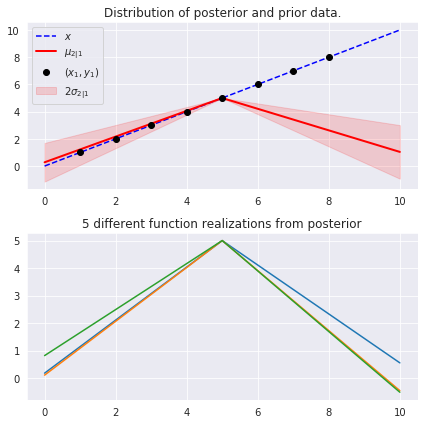

In [7]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
#plt.scatter(years,germanyPopulation)
ax1.plot(X2, f_sin(X2), 'b--', label='$x$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
#plt.yscale('log')
ax1.set_title('Distribution of posterior and prior data.')

ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_title('5 different function realizations from posterior')
plt.tight_layout()

plt.show()
#

In [ ]:
# # kernel setting 

# kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
# model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

# model.fit(trainX, trainY)
# params = model.kernel_.get_params()

In [ ]:
# # prediction and plotting 
# y_pred, std = model.predict(testX, return_std=True)

# plt.grid()
# plt.scatter(trainX,trainY,label='observations')
# plt.scatter(testX,y_pred,label='predictions')
# plt.plot(trainX,trainY,label='mean')
# plt.legend()
    

In [ ]:
import numpy as np 
import random 

a = np.array([[1,2,3,4,5,6,7,8]])
b = np.array([[1,2,3,4,5,6,7,8]])

print(a) 
print(b) 
random.shuffle(a)
print(a)
